## DATA 620 

---
### Project 1 - Alt
### Mael Illien and Jeremy OBrien

* Identify and load a network dataset that has some categorical information available for each node.
* For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
* Compare your centrality measures across your categorical groups.
* For example, using the dataset from a study of romantic relationships among high school students in Columbus, Ohio [http://researchnews.osu.edu/archive/chains.htm], you might want to determine if there are any differences in your calculated centrality measures between the two sexes. You might use a t-test or another statistical measure to support your findings.


In [42]:
import csv
import foursquare
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from config import foursquare_config as fs_config

In [6]:
midtown = pd.read_csv('venues_midtown_unique.csv')
downtown = pd.read_csv('venues_downtown.csv')
westvil = pd.read_csv('venues_westvil_unique.csv')

In [153]:
# Cleanup datasets
midtown = midtown.filter(items=['id', 'name','type'])
downtown = downtown.drop_duplicates()
downtown = downtown.filter(items=['id', 'name','type'])
#downtown = downtown.reset_index()
westvil = westvil.filter(items=['id', 'name','type'])

In [181]:
# Combine the 3 venues data frames into one
venues = midtown
venues = df.append(westvil, ignore_index=True)
venues = df.append(downtown, ignore_index=True)
venues = venues.drop_duplicates()
print(len(venues))
venues.head()

88


,id,name,type,index
0,43695300f964a5208c291fe3,Empire State Building,Building,NaN
1,4bcca12bb6c49c7422169491,86th Floor Observation Deck,Scenic Lookout,NaN
2,49b7ed6df964a52030531fe3,Times Square,Plaza,NaN
3,41102700f964a520d60b1fe3,Macy's,Department Store,NaN
4,40b68100f964a5207d001fe3,Madison Square Park,Park,NaN


In [182]:
# Shrink this into fewer categories: Food&Bev, Entertainment, Store, Park/Plaza, Attraction/Landmark
venues['type'].drop_duplicates()

0              Building
1        Scenic Lookout
2                 Plaza
3      Department Store
4                  Park
7           Candy Store
8      Theme Restaurant
10         Toys & Games
12           Basketball
13              Burgers
14              Gourmet
16      Farmer's Market
18             American
19            Bookstore
20          Coffee Shop
23             Fountain
28        Grocery Store
31    Outdoor Sculpture
32              Falafel
33              Dog Run
34         Indie Movies
35      Performing Arts
36               Market
37           Art Museum
38          Beer Garden
39          Electronics
40                Pizza
41            Cosmetics
43        Movie Theater
44            Wine Shop
45           Comic Shop
47        Memorial Site
50               Bridge
51                 Mall
53         New American
61           Food Court
64             Landmark
65        Historic Site
67               Island
Name: type, dtype: object

In [15]:
midtown['id'][0]

'43695300f964a5208c291fe3'

In [7]:
midtown[midtown['id'] == '43695300f964a5208c291fe3']

,id,name,type
0,43695300f964a5208c291fe3,Empire State Building,Building


In [10]:
# Fill these out to run but don't save to Github
CLIENT_ID = fs_config['id']
CLIENT_SECRET = fs_config['secret']

client = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

In [125]:
def generate_links(locations):
    links = []

    for l in locations['id']:
        #print(l)
        next_locations = client.venues.nextvenues(l)['nextVenues']['items']
        
        for nl in next_locations:
            link = (l, nl['id'])
            #print(link)
            if not link in links:
                #if nl['id'] in locations['id']:
                    #print('adding link')
                links.append(link)          
    return links

def generate_network_from_locations(locations):
    #labels = dict(zip(list(venues['id']),list(venues['name'])))
    links = generate_links(locations)
    #print(links)
    
    G = nx.DiGraph()
    for f, t in links:
        G.add_edge(f, t)
    return G

def generate_network_from_links(venues, links_file):
    # Read links from file which are stored a str representation of tuples
    links = []
    with open(links_file, newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            as_tpl = eval(row[0])
            links.append(as_tpl)
    
    # Create graph
    G = nx.DiGraph()
    for f, t in links:
        G.add_edge(f, t)
        
    # Add attributes to the nodes
    for i in range(len(venues)):
        ven_id = venues['id'][i]
        G.nodes[ven_id]['name'] = venues['name'][i]
        G.nodes[ven_id]['type'] = venues['type'][i]
    # Trim nodes of degree 1 or less
    #small = [n for n in G.nodes if G.degree[n] <= 1]
    #G.remove_nodes_from(small)
        
    return G

In [116]:
#midtown_g = generate_network_from_locations(midtown)
midtown_g = generate_network_from_links(midtown, 'links_midtown.csv')
print(nx.info(midtown_g))

Name: 
Type: DiGraph
Number of nodes: 46
Number of edges: 105
Average in degree:   2.2826
Average out degree:   2.2826


In [110]:
# Make figures bigger
plt.rcParams['figure.figsize'] = [20, 10]

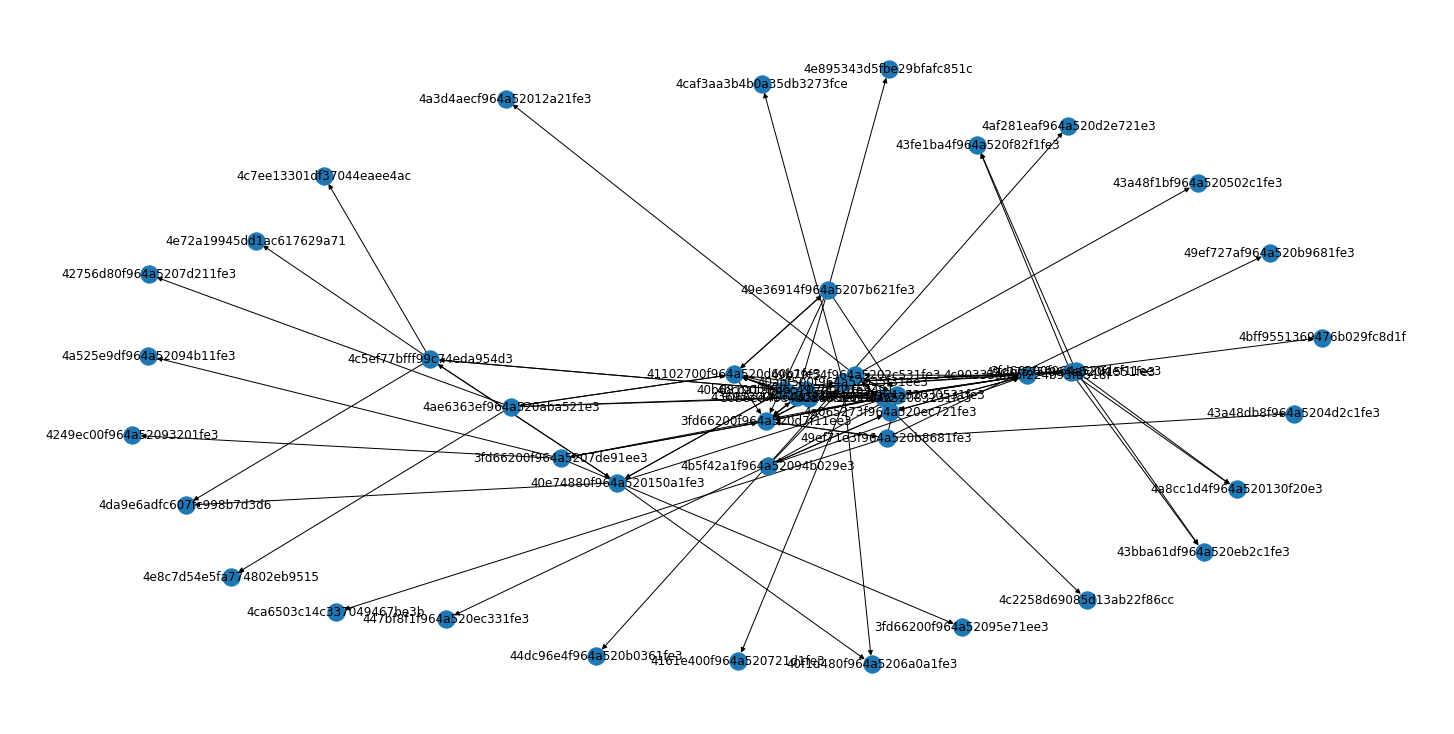

In [183]:
# Midtown only graph
nx.draw(midtown_g, with_labels=True)

In [126]:
downtown_g = generate_network_from_links(downtown, 'links_downtown.csv')
print(nx.info(downtown_g))

Name: 
Type: DiGraph
Number of nodes: 53
Number of edges: 115
Average in degree:   2.1698
Average out degree:   2.1698


In [127]:
westvil_g = generate_network_from_links(westvil, 'links_westvil.csv')
print(nx.info(westvil_g))

Name: 
Type: DiGraph
Number of nodes: 25
Number of edges: 40
Average in degree:   1.6000
Average out degree:   1.6000


In [209]:
# Combine the 3 graphs
comb_g = nx.compose(midtown_g, downtown_g)
comb_g = nx.compose(comb_g, westvil_g)
print(nx.info(comb_g))

Name: 
Type: DiGraph
Number of nodes: 107
Number of edges: 245
Average in degree:   2.2897
Average out degree:   2.2897


In [210]:
comb_g.nodes['43695300f964a5208c291fe3']

{'name': 'Empire State Building', 'type': 'Building'}

In [211]:
# Identify and drop nodes that have no info (too many are droppped)
no_name = [node for node in comb_g.nodes if node not in list(venues['id'])]
comb_g.remove_nodes_from(no_name)
print(nx.info(comb_g))

Name: 
Type: DiGraph
Number of nodes: 65
Number of edges: 199
Average in degree:   3.0615
Average out degree:   3.0615


In [214]:
def get_metrics(venues, graph):

    degree = nx.degree(graph)
    venues['degree'] = [degree[n] for n in venues['id']]

    pagerank = nx.pagerank(graph, alpha=.9)
    venues['pagerank'] = [pagerank[n] for n in venues['id']]

    betweenness = nx.betweenness_centrality(graph)
    venues['betweenness'] = [betweenness[n] for n in venues['id']]
    
    closeness = nx.closeness_centrality(graph)
    venues['closeness'] = [closeness[n] for n in venues['id']]
    
    return venues


In [215]:
metrics = get_metrics(venues, comb_g)

In [216]:
metrics.sort_values(by=['degree'], ascending=False).head()
#metrics.sort_values(by=['degree'], ascending=False).tail()

,id,name,type,index,degree,pagerank,betweenness,closeness
2,49b7ed6df964a52030531fe3,Times Square,Plaza,NaN,21,0.100207,0.071191,0.250164
47,4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (Natio...,Memorial Site,1.0,19,0.053557,0.113659,0.237608
70,4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (Natio...,Memorial Site,NaN,19,0.053557,0.113659,0.237608
69,4abe7f9ef964a520068e20e3,One World Trade Center,Building,NaN,15,0.036169,0.076209,0.191406
46,4abe7f9ef964a520068e20e3,One World Trade Center,Building,0.0,15,0.036169,0.076209,0.191406


In [217]:
metrics.sort_values(by=['pagerank'], ascending=False).head()

,id,name,type,index,degree,pagerank,betweenness,closeness
2,49b7ed6df964a52030531fe3,Times Square,Plaza,NaN,21,0.100207,0.071191,0.250164
47,4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (Natio...,Memorial Site,1.0,19,0.053557,0.113659,0.237608
70,4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (Natio...,Memorial Site,NaN,19,0.053557,0.113659,0.237608
73,4a43bcb7f964a520bba61fe3,Brooklyn Bridge,Bridge,NaN,13,0.053154,0.173723,0.186233
50,4a43bcb7f964a520bba61fe3,Brooklyn Bridge,Bridge,4.0,13,0.053154,0.173723,0.186233


In [218]:
metrics.sort_values(by=['betweenness'], ascending=False).head()

,id,name,type,index,degree,pagerank,betweenness,closeness
73,4a43bcb7f964a520bba61fe3,Brooklyn Bridge,Bridge,NaN,13,0.053154,0.173723,0.186233
50,4a43bcb7f964a520bba61fe3,Brooklyn Bridge,Bridge,4.0,13,0.053154,0.173723,0.186233
15,3fd66200f964a520def11ee3,Union Square Park,Park,NaN,13,0.017862,0.161632,0.244898
17,40abf500f964a52035f31ee3,Washington Square Park,Park,NaN,11,0.014721,0.152679,0.211765
83,4a32c3f9f964a5208c9a1fe3,Manhattan Bridge,Bridge,NaN,5,0.011933,0.148797,0.120888


In [219]:
metrics.sort_values(by=['closeness'], ascending=False).head()

,id,name,type,index,degree,pagerank,betweenness,closeness
2,49b7ed6df964a52030531fe3,Times Square,Plaza,NaN,21,0.100207,0.071191,0.250164
15,3fd66200f964a520def11ee3,Union Square Park,Park,NaN,13,0.017862,0.161632,0.244898
47,4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (Natio...,Memorial Site,1.0,19,0.053557,0.113659,0.237608
70,4b6b5abff964a520fb022ce3,National September 11 Memorial & Museum (Natio...,Memorial Site,NaN,19,0.053557,0.113659,0.237608
5,3fd66200f964a520d7f11ee3,Bryant Park,Park,NaN,14,0.046678,0.053272,0.218033


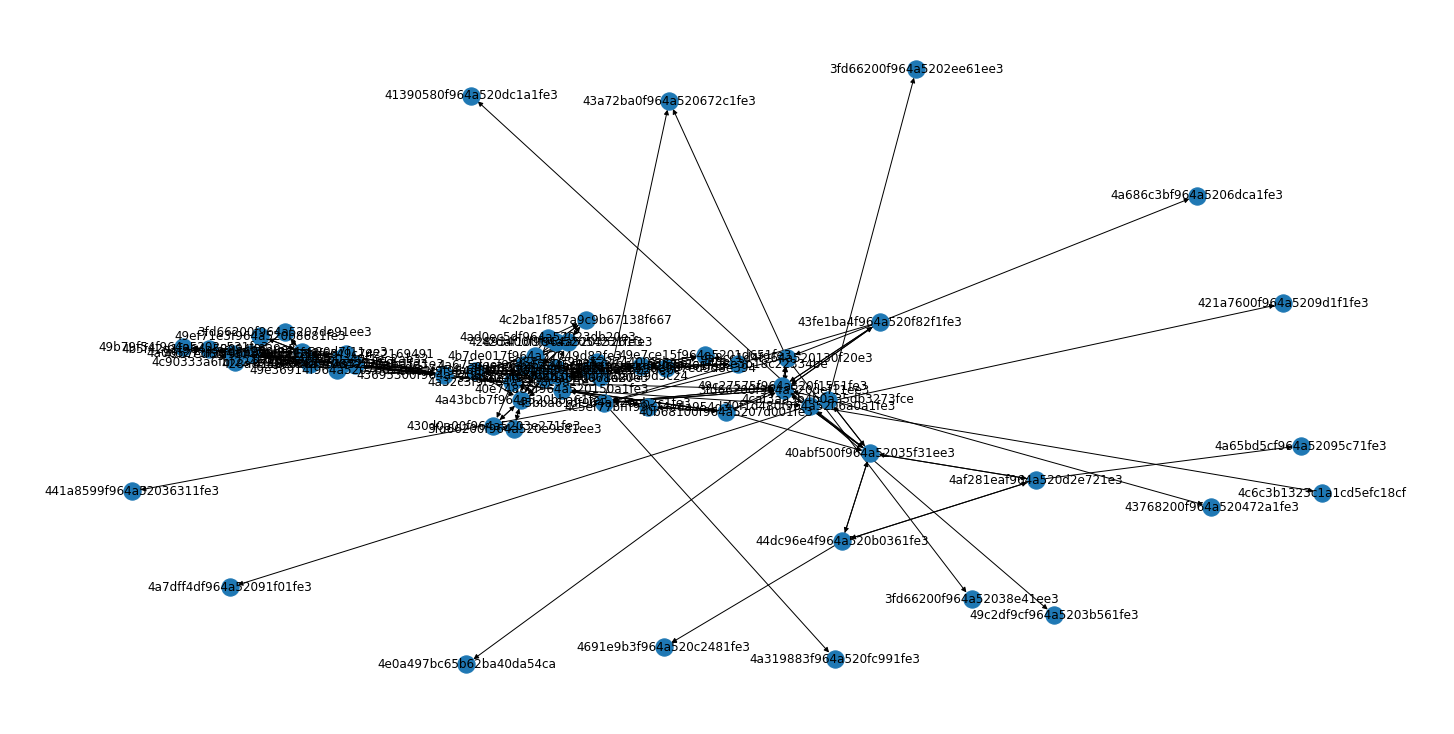

In [223]:
nx.draw(comb_g, with_labels=True)

In [192]:
#small = [n for n in comb_g.nodes if comb_g.degree[n] <= 1]
#comb_g.remove_nodes_from(small)
#print(nx.info(comb_g))

Name: 
Type: DiGraph
Number of nodes: 55
Number of edges: 193
Average in degree:   3.5091
Average out degree:   3.5091


In [221]:
labels = dict(zip(list(venues['id']),list(venues['name'])))
graph_pos = nx.spring_layout(comb_g)

{'43695300f964a5208c291fe3': Text(0.00473450676321286, 0.23887058068560008, 'Empire State Building'),
 '4bcca12bb6c49c7422169491': Text(0.04250121283343421, 0.38372220145233926, '86th Floor Observation Deck'),
 '49b7ed6df964a52030531fe3': Text(0.05566090141269981, 0.5072436211244938, 'Times Square'),
 '41102700f964a520d60b1fe3': Text(0.02515580326762208, 0.3808247474880887, "Macy's"),
 '40b68100f964a5207d001fe3': Text(-0.08002821469140864, -0.15270067609232615, 'Madison Square Park'),
 '3fd66200f964a520d7f11ee3': Text(0.06324204048920078, 0.43545010536228657, 'Bryant Park'),
 '50b6ed46e4b0a40f1ec2ab32': Text(0.0571080707551209, 0.37539689282199323, '102nd Floor Observatory'),
 '4a065273f964a520ec721fe3': Text(0.07206579561079289, 0.5291924241225209, "M&M's World"),
 '428a8580f964a52083231fe3': Text(0.03646111621543665, 0.42495181632381446, 'Hard Rock Cafe'),
 '49b79f54f964a5202c531fe3': Text(0.06899895593384445, 0.5966485487813609, 'Rockefeller Center'),
 '4c90333a6fbf224b93fa518f': Te

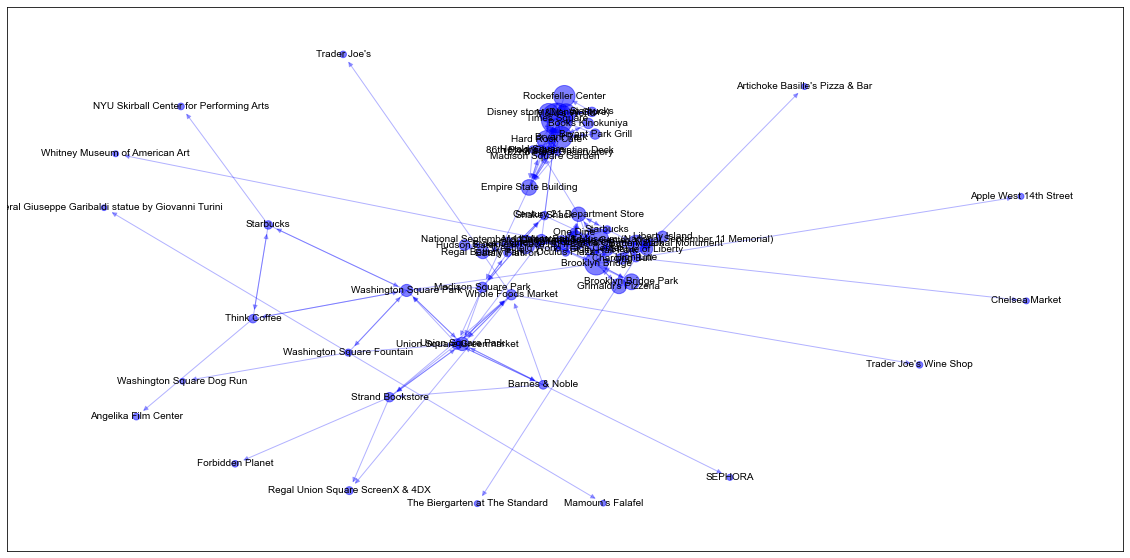

In [222]:
# Plot network

#fig = plt.figure(figsize(16,9), dpi=150)
pagerank = nx.pagerank(comb_g, alpha=.9)
nodesize = [10000 * n for n in pagerank.values()]
nx.draw_networkx_nodes(comb_g, graph_pos, node_size=nodesize, alpha=.5, node_color='blue')
nx.draw_networkx_edges(comb_g, graph_pos, width=1, alpha=.3, edge_color='blue')
nx.draw_networkx_labels(comb_g, graph_pos, labels=labels, font_size=10, font_family='Arial')